<a href="https://colab.research.google.com/github/katarinagresova/M7DataSP_2020/blob/master/assignment_09/TweetRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was created to practise collaborative filtering [assignment 08](https://github.com/simecek/dspracticum2020/tree/master/lecture_09) in subject [Data Science Practicum 2020](https://github.com/simecek/dspracticum2020) and was written following keras example [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/).

#Setup

In [90]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
import matplotlib.pyplot as plt

#Prepare the data

In [91]:
path = keras.utils.get_file(
    "tweet_scores.csv", origin="https://raw.githubusercontent.com/simecek/dspracticum2020/master/lecture_09/assignment/fake_v1_100x252.csv"
)
data = pd.read_csv(path, index_col=0)
data

,tweet1,tweet2,tweet3,tweet4,tweet5,tweet6,tweet7,tweet8,tweet9,tweet10,tweet11,tweet12,tweet13,tweet14,tweet15,tweet16,tweet17,tweet18,tweet19,tweet20,tweet21,tweet22,tweet23,tweet24,tweet25,tweet26,tweet27,tweet28,tweet29,tweet30,tweet31,tweet32,tweet33,tweet34,tweet35,tweet36,tweet37,tweet38,tweet39,tweet40,...,tweet213,tweet214,tweet215,tweet216,tweet217,tweet218,tweet219,tweet220,tweet221,tweet222,tweet223,tweet224,tweet225,tweet226,tweet227,tweet228,tweet229,tweet230,tweet231,tweet232,tweet233,tweet234,tweet235,tweet236,tweet237,tweet238,tweet239,tweet240,tweet241,tweet242,tweet243,tweet244,tweet245,tweet246,tweet247,tweet248,tweet249,tweet250,tweet251,tweet252
user1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,6.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
user2,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,NaN,NaN,6.0,5.0,3.0,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN,...,NaN,3.0,NaN,3.0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
user3,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,...,NaN,4.0,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user4,4.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,4.0,NaN,NaN,NaN,4.0,4.0,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user5,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,4.0,NaN,5.0,NaN,4.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,4.0,NaN,4.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user96,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,5.0,3.0,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,4.0,NaN,5.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,4.0,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN
user97,NaN,4.0,4.0,NaN,NaN,4.0,NaN,4.0,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,4.0,NaN,NaN,4.0,NaN,...,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,4.0,NaN,NaN,NaN,NaN
user98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,4.0,NaN
user99,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN


To follow Collaborative Filtering tutorial we need to reshape our data to form `[userId, tweetId, rating]` and keep only combinations with non-nan ratings.

In [92]:
df = pd.DataFrame([user, tweet, data[tweet][user]] for user in data.index for tweet in data.columns if not math.isnan(data[tweet][user]))
df.columns=['userId', 'tweetId', 'rating']
df

,userId,tweetId,rating
0,user1,tweet1,4.0
1,user1,tweet21,5.0
2,user1,tweet24,5.0
3,user1,tweet27,5.0
4,user1,tweet40,4.0
...,...,...,...
4995,user100,tweet234,4.0
4996,user100,tweet237,3.0
4997,user100,tweet248,5.0
4998,user100,tweet249,5.0


Now we need to perform some preprocessing to encode users and tweets as integer indices.

In [93]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
tweet_ids = df["tweetId"].unique().tolist()
tweet2tweet_encoded = {x: i for i, x in enumerate(tweet_ids)}
tweet_encoded2tweet = {i: x for i, x in enumerate(tweet_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["tweet"] = df["tweetId"].map(tweet2tweet_encoded)

num_users = len(user2user_encoded)
num_tweets = len(tweet_encoded2tweet)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Tweets: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_tweets, min_rating, max_rating
    )
)

Number of users: 100, Number of Tweets: 252, Min rating: 1.0, Max rating: 6.0


#Prepare training and validation data

In [94]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "tweet"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

#Create the model

We embed both users and tweet in to 50-dimensional vectors.

The model computes a match score between user and tweet embeddings via a dot product, and adds a per-tweet and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).

In [95]:
EMBEDDING_SIZE = 10

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_tweets, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_tweets = num_tweets
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.tweet_embedding = layers.Embedding(
            num_tweets,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.tweet_bias = layers.Embedding(num_tweets, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        tweet_vector = self.tweet_embedding(inputs[:, 1])
        tweet_bias = self.tweet_bias(inputs[:, 1])
        dot_user_tweet = tf.tensordot(user_vector, tweet_vector, 2)
        # Add all the components (including bias)
        x = dot_user_tweet + user_bias + tweet_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_tweets, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
)

#Train the model based on the data split

In [96]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=50,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/50
71/71 [==============================] - 0s 6ms/step - loss: 0.7025 - accuracy: 0.0071 - val_loss: 0.7039 - val_accuracy: 0.0080
Epoch 2/50
71/71 [==============================] - 0s 4ms/step - loss: 0.6764 - accuracy: 0.0124 - val_loss: 0.6985 - val_accuracy: 0.0100
Epoch 3/50
71/71 [==============================] - 0s 4ms/step - loss: 0.6696 - accuracy: 0.0142 - val_loss: 0.6950 - val_accuracy: 0.0120
Epoch 4/50
71/71 [==============================] - 0s 4ms/step - loss: 0.6678 - accuracy: 0.0147 - val_loss: 0.6942 - val_accuracy: 0.0120
Epoch 5/50
71/71 [==============================] - 0s 4ms/step - loss: 0.6711 - accuracy: 0.0140 - val_loss: 0.6927 - val_accuracy: 0.0120
Epoch 6/50
71/71 [==============================] - 0s 4ms/step - loss: 0.6701 - accuracy: 0.0138 - val_loss: 0.6944 - val_accuracy: 0.0120
Epoch 7/50
71/71 [==============================] - 0s 4ms/step - loss: 0.6687 - accuracy: 0.0142 - val_loss: 0.6951 - val_accuracy: 0.0120
Epoch 8/50
71/71 [==

#Plot training and validation accuracy

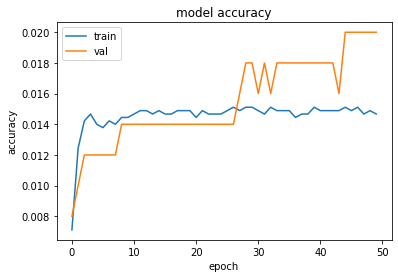

In [97]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()


# Predict score for all tweets

Just a reminder, this is our input table with missing scores.

In [98]:
data

,tweet1,tweet2,tweet3,tweet4,tweet5,tweet6,tweet7,tweet8,tweet9,tweet10,tweet11,tweet12,tweet13,tweet14,tweet15,tweet16,tweet17,tweet18,tweet19,tweet20,tweet21,tweet22,tweet23,tweet24,tweet25,tweet26,tweet27,tweet28,tweet29,tweet30,tweet31,tweet32,tweet33,tweet34,tweet35,tweet36,tweet37,tweet38,tweet39,tweet40,...,tweet213,tweet214,tweet215,tweet216,tweet217,tweet218,tweet219,tweet220,tweet221,tweet222,tweet223,tweet224,tweet225,tweet226,tweet227,tweet228,tweet229,tweet230,tweet231,tweet232,tweet233,tweet234,tweet235,tweet236,tweet237,tweet238,tweet239,tweet240,tweet241,tweet242,tweet243,tweet244,tweet245,tweet246,tweet247,tweet248,tweet249,tweet250,tweet251,tweet252
user1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,6.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
user2,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,NaN,NaN,6.0,5.0,3.0,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN,...,NaN,3.0,NaN,3.0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
user3,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,...,NaN,4.0,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user4,4.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,4.0,NaN,NaN,NaN,4.0,4.0,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user5,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,4.0,NaN,5.0,NaN,4.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,4.0,NaN,4.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user96,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,5.0,3.0,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,4.0,NaN,5.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,4.0,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN
user97,NaN,4.0,4.0,NaN,NaN,4.0,NaN,4.0,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,4.0,NaN,NaN,4.0,NaN,...,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,4.0,NaN,NaN,NaN,NaN
user98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,4.0,NaN
user99,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN


There is definitely a better way than doing it one by one in nested for loop, but I wanted to make sure I will not missmatch indices. So run this only if you have few spare minutes.

In [99]:
def scale_score(score):
  '''
  Scales score from interval <0, 1> to interval <min_rating, max_rating>.
  '''
  return score * (max_rating - min_rating) + min_rating

In [100]:
for user in data.index: 
    for tweet in data.columns:
        if math.isnan(data[tweet][user]):
            user_id = user2user_encoded[user]
            tweet_id = tweet2tweet_encoded[tweet]
            predicted = model.predict([[user_id, tweet_id]])
            data[tweet][user] = scale_score(predicted[0][0])

In [101]:
data

,tweet1,tweet2,tweet3,tweet4,tweet5,tweet6,tweet7,tweet8,tweet9,tweet10,tweet11,tweet12,tweet13,tweet14,tweet15,tweet16,tweet17,tweet18,tweet19,tweet20,tweet21,tweet22,tweet23,tweet24,tweet25,tweet26,tweet27,tweet28,tweet29,tweet30,tweet31,tweet32,tweet33,tweet34,tweet35,tweet36,tweet37,tweet38,tweet39,tweet40,...,tweet213,tweet214,tweet215,tweet216,tweet217,tweet218,tweet219,tweet220,tweet221,tweet222,tweet223,tweet224,tweet225,tweet226,tweet227,tweet228,tweet229,tweet230,tweet231,tweet232,tweet233,tweet234,tweet235,tweet236,tweet237,tweet238,tweet239,tweet240,tweet241,tweet242,tweet243,tweet244,tweet245,tweet246,tweet247,tweet248,tweet249,tweet250,tweet251,tweet252
user1,4.000000,4.084471,4.168460,3.934974,4.194443,3.898702,3.886705,3.914925,4.139655,4.121608,3.988855,4.032219,3.898693,3.827119,3.829804,3.859578,3.873021,3.923827,3.966206,3.837453,5.000000,4.122499,4.184925,5.000000,3.845328,3.980710,5.000000,3.854678,3.885168,4.118688,4.019426,3.943163,3.837387,3.896862,4.070771,3.884692,4.090025,3.865121,4.019326,4.000000,...,3.912518,6.000000,4.066049,3.979770,4.083590,4.000000,4.082146,4.010417,3.986791,3.923076,4.249139,3.982817,3.932585,4.060135,4.119143,4.000000,3.817432,3.628275,5.000000,3.977152,3.981281,3.680494,3.996856,3.855762,4.057241,4.256674,6.000000,3.852453,4.167506,4.079578,3.000000,3.000000,4.025638,4.259013,3.892478,4.214631,4.021607,4.031425,4.089488,5.000000
user2,3.743261,3.882534,4.006325,5.000000,4.004760,5.000000,3.721436,3.710497,3.932461,3.896651,6.000000,5.000000,3.000000,3.680807,4.000000,3.666220,3.663127,3.707503,3.784334,4.000000,3.900296,3.965451,4.009579,3.000000,3.000000,3.840844,4.117790,3.679610,5.000000,3.937912,3.851747,5.000000,3.649963,3.707103,3.882666,4.000000,3.915836,3.676378,5.000000,3.675855,...,3.706892,3.000000,3.862794,3.000000,3.896475,3.916656,6.000000,3.818864,3.791294,3.777042,4.054278,3.829675,3.771958,3.832842,3.000000,4.000000,4.000000,3.485399,3.930259,3.785991,3.831395,3.491388,3.794089,3.000000,3.847224,4.108032,4.032543,3.703551,3.985485,6.000000,3.874985,4.000000,3.825603,4.102356,3.719565,4.061669,3.000000,3.842796,3.899255,4.069009
user3,3.739639,4.000000,3.960816,3.719772,3.979007,3.630691,4.000000,3.722650,3.889659,3.879207,3.759504,3.820375,4.000000,3.696238,3.631456,3.662259,4.000000,3.750883,3.776315,3.579455,3.945229,3.880575,3.986637,3.872156,3.641940,3.747316,4.039805,3.634662,3.642226,3.926766,3.777481,3.726658,3.617705,3.710605,3.804578,3.659314,3.881692,4.000000,3.807410,4.000000,...,3.683642,4.000000,5.000000,3.723497,5.000000,3.848127,3.884867,3.771967,3.741780,3.705399,4.088524,3.711962,3.690614,3.810220,3.890163,4.000000,3.537347,3.392004,3.929765,4.000000,3.736046,3.491672,3.809728,3.647927,3.802589,3.995887,3.952653,3.638264,3.970084,3.829121,3.811208,4.028002,3.825991,4.031498,3.679503,3.986922,3.783090,3.814811,3.829065,3.984151
user4,4.000000,3.660906,3.783585,3.524710,3.765861,4.000000,3.518104,4.000000,3.742855,4.000000,3.635246,3.656584,3.567893,4.000000,4.000000,3.521580,4.000000,3.581443,3.606228,3.447125,4.000000,3.714876,3.840213,3.728516,4.000000,3.598540,3.892920,4.000000,3.417505,3.765551,3.637761,3.531864,3.424229,3.498500,3.661659,3.476262,4.000000,3.424675,3.649263,3.490431,...,3.539451,3.482947,3.643880,4.000000,4.000000,3.702692,3.752341,3.560216,3.547348,4.000000,3.891504,3.533725,3.535081,3.624101,3.643350,4.000000,3.343700,3.308677,4.000000,4.000000,3.572569,3.318012,3.583058,3.474865,3.626079,3.927338,3.831129,3.456290,3.747267,5.000000,3.638293,4.000000,3.624752,3.902390,3.502163,3.830469,3.635979,3.657310,3.638791,3.832108
user5,3.739484,3.922858,5.000000,3.791390,3.988807,3.689195,3.659929,3.687633,3.968717,3.860983,3.723740,3.830377,3.635799,3.616756,3.583319,3.656697,3.740882,5.000000,3.733034,3.631530,4.000000,3.942238,4.000000,3.932728,5.000000,3.806667,4.000000,3.668277,3.684296,3.958826,6.000000,3.679792,3.656342,3.692528,3.825787,3.664245,3.967725,3.648574,3.873144,3.625741,...,3.770882,4.000000,3.874645,3.79796